# Unsupervised Whistle Repertoire Classification

In the field of Dolphin Acoustics, it is often highly desirable to have an automated means of categorising whistles from several dolphins in various ways. This investigation will specifically look at how a large dataset of signature whistles from different dolphins (see [here](https://www.science.org/content/article/dolphins-can-call-each-other-not-name-whistle) for a brief introduction) can be classified.

This notebook describes a possible method for unsupervised (or perhaps semi-supervised) classification of whistles. It seeks to serve as an alternative for the [ARTWarp algorithm](https://github.com/dolphin-acoustics-vip/artwarp) as described by [Deckee and Janik (2006)](https://doi.org/10.1121/1.2139067).

This method aims to maintain most of the elements of dynamic time-warping implemented by Deckee and Janik for comparison of whistles, but will not use their ART neural network (combined with whistle "averaging") approach for categorisation. Instead, a more straightforward approach of pairwise comparison of each whistle will be used.

For other work in the VIP exploring sunsupervised whistle classification (but with dimensionality reduction methods), see https://github.com/dolphin-acoustics-vip/Unsupervised-Whistle-Classification.

In [ ]:
# import necessary modules
!pip install dtaidistance
import numpy as np
import matplotlib.pyplot as plt
from dtaidistance import dtw, similarity
from scipy import signal
from os import listdir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.1 MB/s eta 0:00:00


# Loading the Dataset

The dataset used is a subset of the Sarasota dataset made available to the VIP. This comprises 60 signature whistles, 30 for each category. This gives a total of 1800 whistles. The code cell below simply loads the data from a CSV file. It should be noted that a small (but perhaps noteworthy) difference between this code and the methods performed [here](https://github.com/dolphin-acoustics-vip/Unsupervised-Whistle-Classification/tree/main) is that the whistle data can be of different lengths (in time). As the clustering algorithm discussed here is very much centred around dynamic time warping, care was taken not to standardise whistle lengths to prevent any element of time-warping being introduced before formal anlaysis is conducted.

In [ ]:
# code in this cell adapted from work done by Ayam Babu at
# https://github.com/dolphin-acoustics-vip/Unsupervised-Whistle-Classification/blob/main/Ayam%20Unsupervised%20Whistle%20Classification%20S1%202023-24.ipynb
! rm -rf Full_dataset/.ipynb_checkpoints
sarasota_dir_path = "Full_dataset"
sarasota_whistle_paths = listdir(sarasota_dir_path)
print(str(len(sarasota_whistle_paths)) + " whistles in the dataset")


# Gather individual names and signature whistles from the Sarasota dataset and store them in separate lists
import pandas as pd

whistle_labels = []
signature_whistles = []

for sarasota_whistle_path in sarasota_whistle_paths:
    whistle_label = sarasota_whistle_path.split("-")[0]
    whistle_labels.append(whistle_label)

    signature_whistle = pd.read_csv(sarasota_dir_path + "/" + sarasota_whistle_path)
    signature_whistles.append(signature_whistle)


whistles = []

for signature_whistle in signature_whistles:
    size = len(signature_whistle)
    newsize = 400

    xloc = np.arange(size)
    new_xloc = np.linspace(0, size, newsize)
    new_sw = signature_whistle[" Peak Frequency [Hz]"]
    whistles.append(new_sw)

whistles = [np.array(whistle.tolist()) for whistle in whistles]
whistle_labels = np.array(whistle_labels)
print(np.shape(whistle_labels))

1800 whistles in the dataset
(1800,)


# Exploring the Dtaidistance Library

Here we first explore the dynamic time warping functionality of the dtaidistance library and do some timing tests with toy data. This coding section is the "rough work" before a proper classification function is written.

The metric for similarity (or equivalently distance) between two time series is calculated using the [`dtaidistance`](https://github.com/wannesm/dtaidistance/tree/master) Python library. This library has built-on dynamic time warping measures which can be further explored [here](https://dtaidistance.readthedocs.io/en/latest/usage/dtw.html). The steps involved in making a distance metric are outlined below.

## Step 1: Get Normalised Similarity score
The `dtaidistance` library offers a way of gaining a normalised similarity score with a score of $1$ representing a perfect macth between whistles and a score of $0$ representing completely dissimilar whistles.

## Step 2: Convert to Distance Score
It was found that it was more convenient to work with a notion of distances betwen whistles such that a distance score of $1$ represents a complete mismatch and a score of $0$ indicates a perfet match. THe conversion is given by the simple formula:
$$distance = 1 - similarity$$

## Step 3: Clustering whistles
All whistles below a certain (user-specified) distance threshold will be said to be similar. A matrix of distance scores (each row representing a whistle) is prouced giving the pairwise distance score between all whistles. If a whistle is above this threshold when compared to another whistle, it is said to be dissimilar and is eliminated from the corresponding row.

## Step 4: Getting Unique Clusters
Each row constitutes a different group of whistles. In general, these rows may not be unique so only unique rows from the matrix are taken to be a cluster (i.e. all rows which do not share exactly the same elements and number of elements).

In [ ]:
%%time
from dtaidistance import dtw, similarity
# initialise a list of random time series
s = np.random.rand(50,400)
print("inital list of (arbitrary) time-series:")
print(s)
print()

# get distance matrix from data
sim = similarity.distance_to_similarity(dtw.distance_matrix_fast(s))
print("normlaised distance matrix from time series:")
print(sim)
print()

# convert similarity metric to distance
dist = np.ones(np.shape(sim)) - sim
print("similarity matrix from distance matrix (similarity score= 1 - distance score):")
print(dist)
print()

# find all series which have distance below certain threshold
a=np.where(dist<=0.2)
b=np.where(dist>0.2)
dist[a] = a[1]
dist[b] = -1 # set to negative number if not part of category
print("distance matrix with all non-matches set to -1:")
print(dist)
print()

# get unique combinations of matches
c = np.unique(dist, axis=0)
print("unique combinations of matches:")
print(c)
print()

# remove non-matches
d = [arr[arr!=-1] for arr in c]
print("unique combinations of matches with -1s removed:")
print(d)

inital list of (arbitrary) time-series:
[[0.91370706 0.94124288 0.40588931 ... 0.05900139 0.78745134 0.16109174]
 [0.44288015 0.7518345  0.96169766 ... 0.87050524 0.64640762 0.50921591]
 [0.748212   0.03251489 0.79313004 ... 0.48506947 0.68014943 0.73482191]
 ...
 [0.02874174 0.46955006 0.23318608 ... 0.87302422 0.09755244 0.78616244]
 [0.04838763 0.45459984 0.23880705 ... 0.71330895 0.80903295 0.11186997]
 [0.86082419 0.81831683 0.03351723 ... 0.00123302 0.86349444 0.60612344]]

normlaised distance matrix from time series:
[[1.         0.40764266 0.40240682 ... 0.38805516 0.39678874 0.40352563]
 [0.40764266 1.         0.40779663 ... 0.40376626 0.39934316 0.41148719]
 [0.40240682 0.40779663 1.         ... 0.38676917 0.39579108 0.39581071]
 ...
 [0.38805516 0.40376626 0.38676917 ... 1.         0.40814881 0.39426695]
 [0.39678874 0.39934316 0.39579108 ... 0.40814881 1.         0.38793391]
 [0.40352563 0.41148719 0.39581071 ... 0.39426695 0.38793391 1.        ]]

similarity matrix from di

# Formalising the Code
Here, a formal function is written which returns lists of whistles in their different categories as well as the list indices associated with their original order (to keep track of whistles uniquely).

## Comparison with Dynamic Time Warping implemented by Deckee and Janik
This function tries to keep as much as possible from the implementation of dynamic time warping implemented by Deckee and Janik within the constrainst provided by the `dtaidistance` Python library. A "warping factor" limit of three times te modal time series lengthe is imposed, similar to the limit imposed by Deckee and Janik for comparing a whistle to a reference contour. The notion of a reference contour does not exactly exist in this implementation, so three times the modal time series lenth was taken instead.

In contrast to the implementation by Deckee and Janik, this implementation also allows the user to specify a penalty for warping. This is useful as it provide some added flexibility which could not be achieved from setting a maximum window size for whistle warping.

In [ ]:
def get_categories(contours, dist_threshold=0.3, penalty=None):

  # create similarity matrix

  # calculate modal time series length
  modal_length = max(set([len(i) for i in contours]), key=[len(i) for i in contours].count)
  similarity_matrix = similarity.distance_to_similarity(dtw.distance_matrix_fast(contours, penalty=penalty, window=int(3*modal_length)))

  # create distance matrix, ensuring that distance = 1 - similarity
  # Note that the default distance calculation is not normalised
  dist_matrix = np.ones(np.shape(similarity_matrix)) - similarity_matrix


  # assign indices corresponding to contours which match in terms of distance
  similar_indices=np.where(dist_matrix<=dist_threshold)
  dissimilar_indices=np.where(dist_matrix>dist_threshold)

  dist_matrix[similar_indices] = similar_indices[1] # set matching whistle positions equal to column indices
                                                    # of contours

  # non-similar contours in each row the value of -1
  # Note that this is a safe identifier for removal of dissimilar pairs
  # because the distance metric is non-negative.
  dist_matrix[dissimilar_indices] = -1

  # keep unique categories of contours
  unique_categories = np.unique(dist_matrix, axis=0)

  # remove non-matches marked by -1
  unique_categories = [arr[arr!=-1] for arr in unique_categories]

  # return categorised list of whistles
  # return unique_categories, [contours[arr.astype(int)] for arr in unique_categories]
  return unique_categories, [[contours[i] for i in arr.astype(int).tolist()] for arr in unique_categories]

# Testing Code on Synthetic Data

Here the code is tested on a slightly more realistic example, using 350 different "whistle contours. Comparing this to the above timing result seems to suggest that the distance calculation between whistle contours is quadratic in time.

CPU times: user 1min 8s, sys: 428 ms, total: 1min 9s
Wall time: 54.4 s


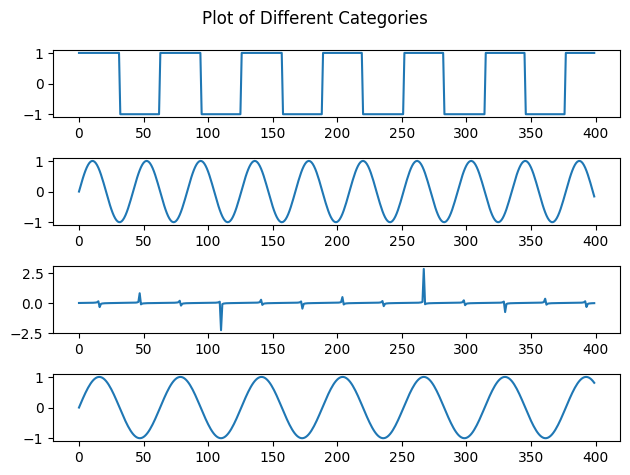

In [ ]:
%%time

a = np.sin(0.1*np.arange(0, 400))
b = np.cos(0.1*np.arange(0, 400))
c = 0.01*np.tan(0.1*np.arange(0, 400))
d = np.sin(0.15*np.arange(0, 400))
e = np.cos(0.15*np.arange(0, 400))
f = 0.01*np.tan(0.15*np.arange(0, 400))
g = signal.square(0.1*np.arange(0, 400))

test_category_indices, test_categories = get_categories(50*[a, b, c, d, e, f, g])

fig, axes = plt.subplots(len(test_categories), 1)
for i, ax in enumerate(axes):
  ax.plot(test_categories[i][0])
fig.suptitle("Plot of Different Categories")
fig.tight_layout()

# Analysing the Sarasota Dataset

With some basic verification of the functionality of the code, we now test ont the real Sarasota dataset. Note that for (preliminarily) categorising the whistles, the runtime is typically under three minutes, a marked improvement over ARTWarp. Here, the equivalent of a $95\%$ vigilance parameter is used.

# Clustering Whistles on Logarithmic Scale
As was highlighted by Deckee and Janik, dolphin whistles should be analused on a logarithmic scale. As such, all whistles are log-transformed to decibels before being fed to the clustering algorithm.

In [ ]:
%%time

whistles2 = [10*np.log10(whistle) for whistle in whistles]

category_indices, categories = get_categories(whistles2, dist_threshold=0.05, penalty=-1) # best: 0.05, penalty -1
category_ind = [set(arr.astype(int).tolist()) for arr in category_indices]
category_names = [whistle_labels[arr.astype(int)].tolist() for arr in category_indices]
print(len(categories))
print(category_names)

1690
[['FB45'], ['F228'], ['F152'], ['F133'], ['F228'], ['FB21'], ['F294'], ['FB45'], ['F133'], ['F150'], ['F155'], ['F267'], ['F294'], ['F152'], ['F150'], ['F155'], ['F228'], ['F155'], ['F152'], ['F150'], ['F152'], ['FB05', 'FB05'], ['F152'], ['F133'], ['F155', 'F155'], ['F155'], ['F272', 'F272'], ['F109'], ['F272'], ['F152'], ['F267'], ['F155'], ['F133', 'F133'], ['F155', 'F155'], ['F109', 'F109'], ['F155'], ['F267', 'F267', 'F267', 'F267'], ['F133'], ['F152'], ['F246'], ['FB20', 'FB20', 'FB20', 'FB20', 'FB20'], ['F221'], ['F228'], ['F272'], ['F152'], ['F246'], ['F298'], ['F152', 'F152'], ['F152'], ['F155'], ['FB45', 'FB45', 'FB45'], ['FB20'], ['F155', 'F155'], ['F155'], ['F150', 'F150'], ['F152'], ['F155'], ['F150'], ['F109', 'F109'], ['F267', 'F267'], ['F265'], ['F150'], ['FB45'], ['F266', 'F266', 'F266'], ['F267'], ['F310', 'F310'], ['FB05'], ['F155', 'F155', 'F155'], ['FB09'], ['FB20'], ['F155'], ['F267', 'F267', 'F267', 'F267', 'F267', 'F267'], ['F109', 'F109', 'F109', 'F109', '

# Analysing Categories

One of the open questions of unsuprevised whistle classification was the extent to which there might be overlap among categories. However, most methods do not allow this to be quantified. Here is a test is conducted of the pairwise intersection among categories. Note that as there are currently over 1000 catgories (reduction of this number will be discussed further down), there are a vast number of possibl pairwise intersections. A histogram is shown below. It seems to suggest that classification can actually be quite "messy" if there is no a priori assumption of whistles being in the same category.

Below some example whistles from different categories are also shown.

1328


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



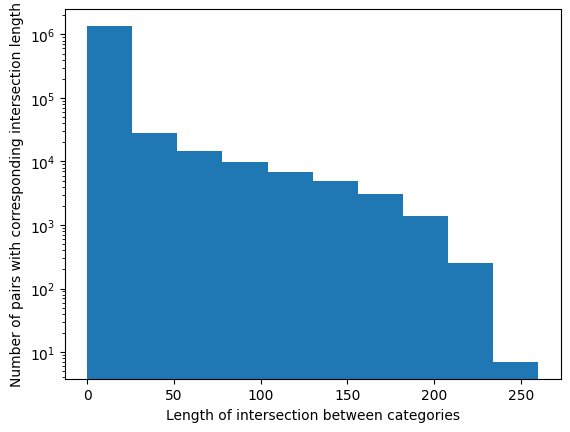

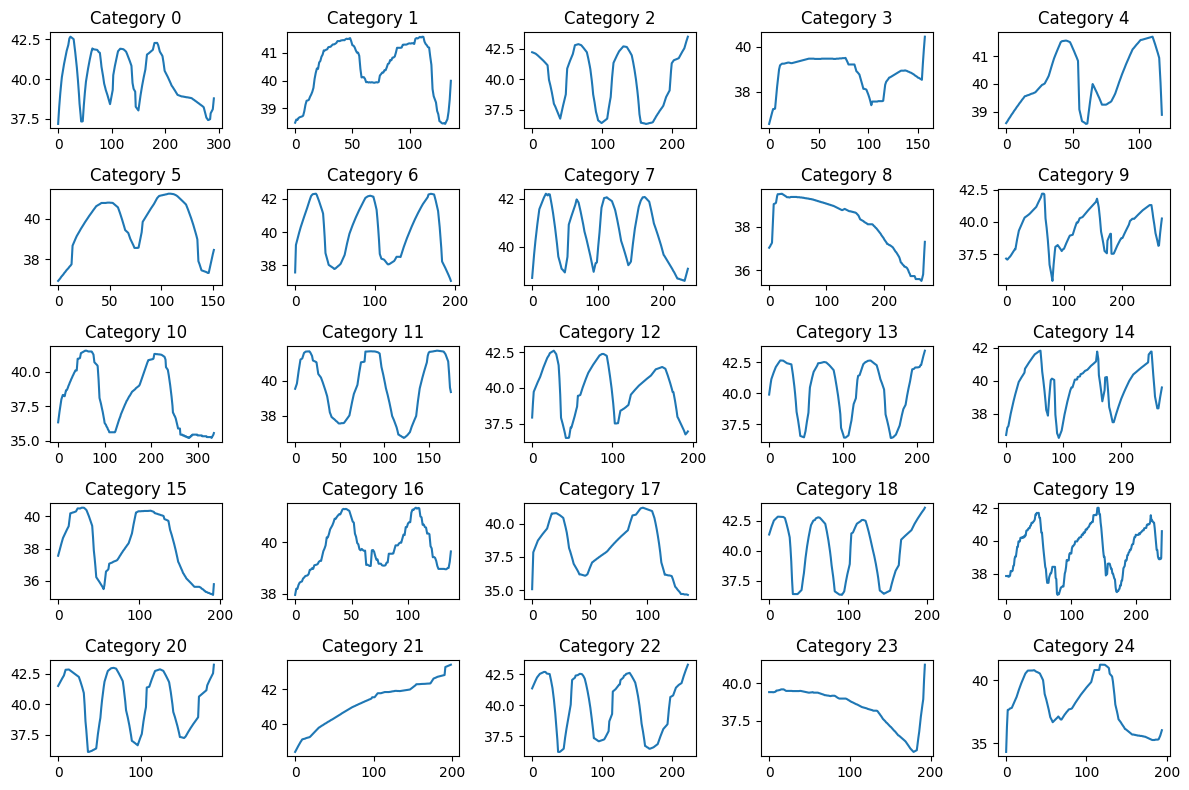

In [ ]:
import itertools


# lambda function solution adapted from solution by user doug at
# https://stackoverflow.com/questions/27369373/pairwise-set-intersection-in-python

# lambda function to get intersection between whistle categories
get_intersection = lambda a, b: category_ind[a].intersection(category_ind[b])
pairs = itertools.combinations(range(len(category_ind)), 2)
res = dict([ (category, get_intersection(*category)) for category in pairs ])

#plt.hist([len(val) for val in res.values()])
plt.hist([len(res[key]) for key in res.keys()])

plt.yscale("log")
plt.ylabel("Number of pairs with corresponding intersection length")
plt.xlabel("Length of intersection between categories")


# print examples from whistle categories
num_cols = 5
num_rows = int(len(categories)/num_cols)

fig, axes = plt.subplots(5, num_cols, figsize=(12, 8))

for row_index, ax_row in enumerate(axes):
  for col_index, ax_col in enumerate(ax_row):
    category_num = num_cols*row_index + col_index
    ax_col.set_title(f"Category {category_num}")
    if category_num < len(categories):
      ax_col.plot(categories[num_cols*row_index + col_index][0])

fig.tight_layout()

# Getting Final Categories

As seen above, there was a very large number of caetgories obtained from simply grouping by Dynamic Time Warping Distance. However, there are a few techniques that can be used to remove possibly unccessary categories:

## Removing Sets which are Pure Subsets
All sets which are simply subsets of larger categories (but which were not removed previously because they are technically distinct categories) are now removed.

## Combining Categories with Significant Overlap
Categories with significant overlap as defined by two parameters (upper and lower bounds) are combined. If a set has at least an overlap of $35\%$ with another, their union is appended to a final list of categories. However, if a list has an overlap of over $90\%$ with an existing category in the final list, the two categories are merged wihtout discarding any whistles at this stage. This combination of low and high percentage overlap checks seems empirically to perform the best. These parameters could however, be varied more formally to maximise performance on this dataset. This, however, would now constitute a semi-supervised approach (as alluded to in the beginning).

## Discarding Uncategorisable Whistles
If a whistle is found not to be long to any category whatsoever after all of the above steps have been taken, it is deemed uncategorisable and hence discarded. This is not ideal, but is somehwat analogous to the discarding of a reference conout with only a single whistle in ARTWarp.

# Displaying Categories
Taking inspiration from both the ARTWarp output style and the presentation of data used by [Oswald et al, 2021](https://doi.org/10.1098/rstb.2021.0046), the final categories are shown in a recatngular array and each whistle belonging to a category is plotted appropriately.

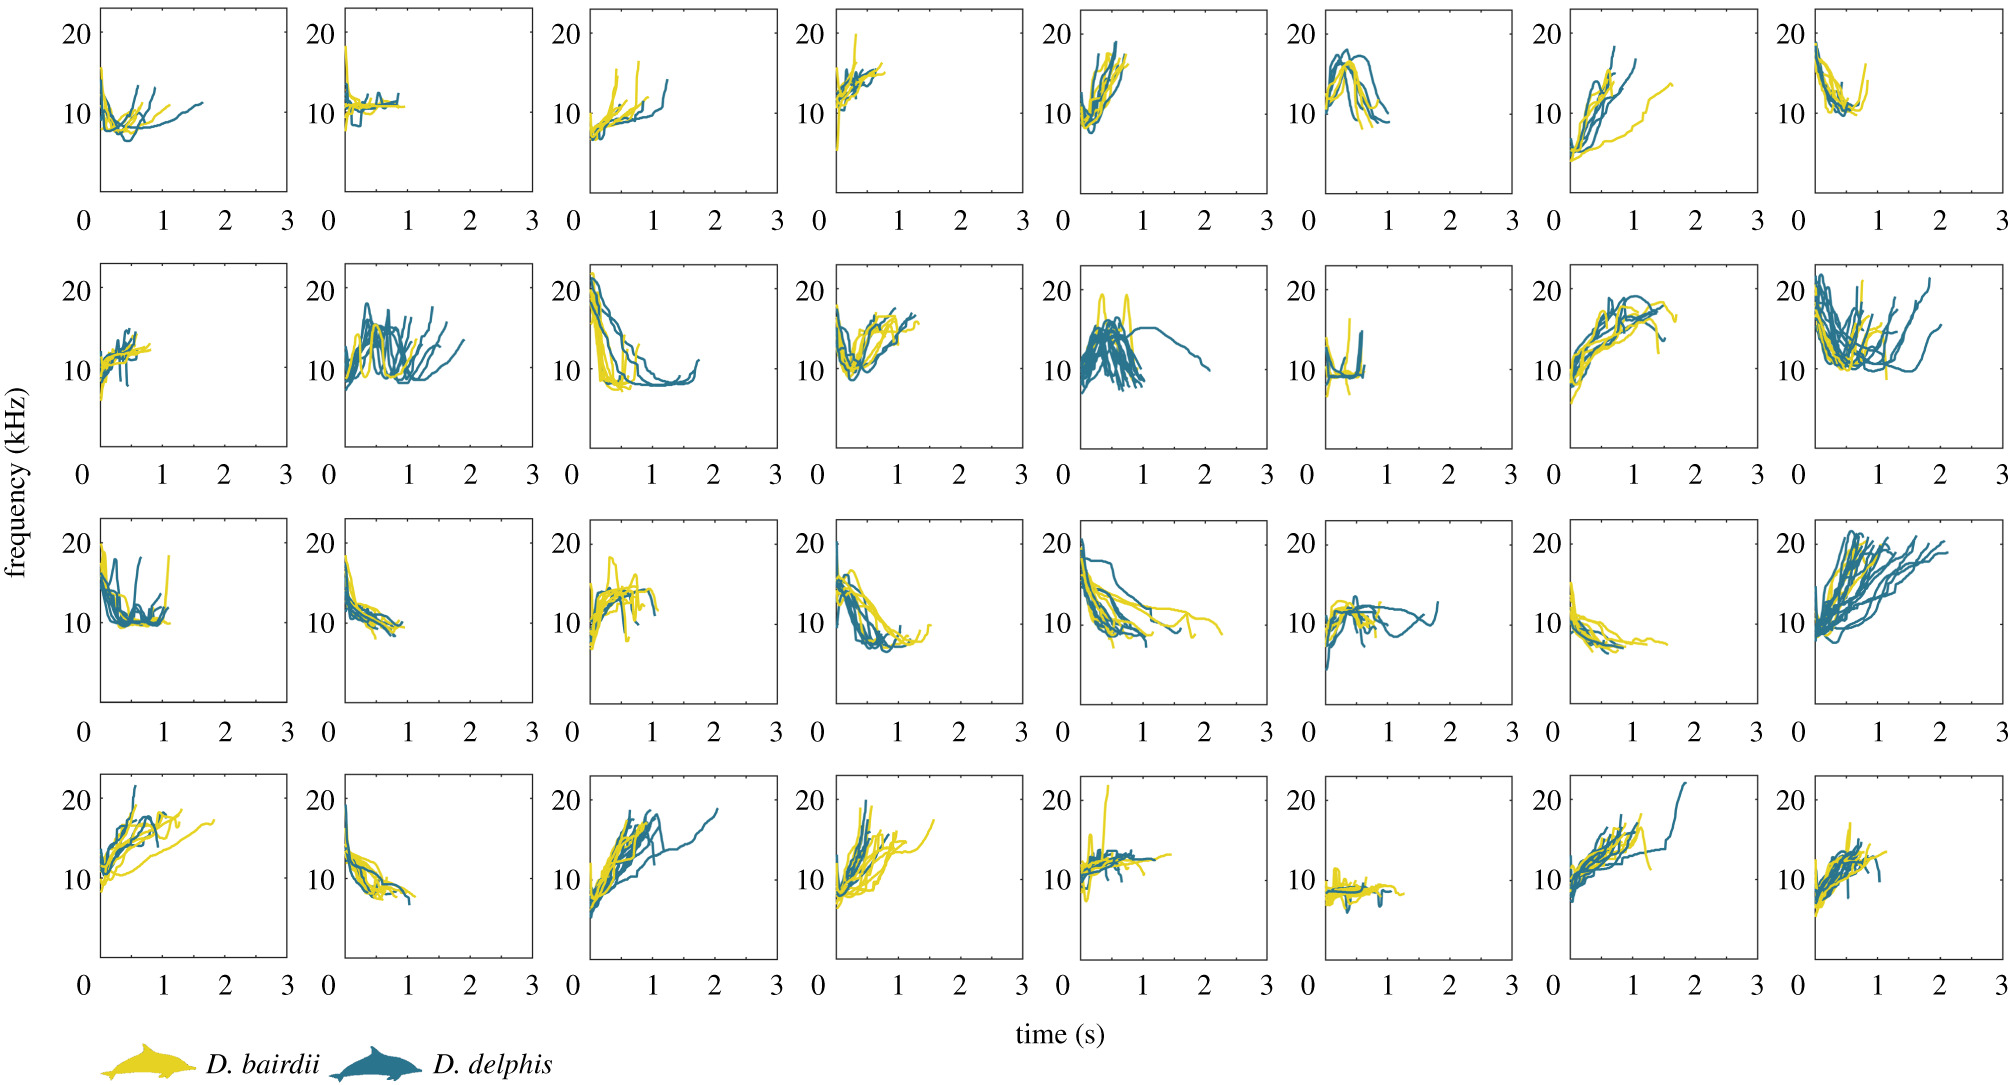

Image from Figure 1 of "Species information in whistle frequency modulation patterns of common dolphins" by Julie N. Oswald, Sam F. Walmsley, Caroline Casey, Selene Fregosi, Brandon Southall and Vincent M. Janik (2021), Philosophical Transactions of the Royal Society B. https://doi.org/10.1098/rstb.2021.0046

1766
60 1800 1766
Number of Categories: 34 
Subsets removed: 722 
Uncategorisable single whistles: 91


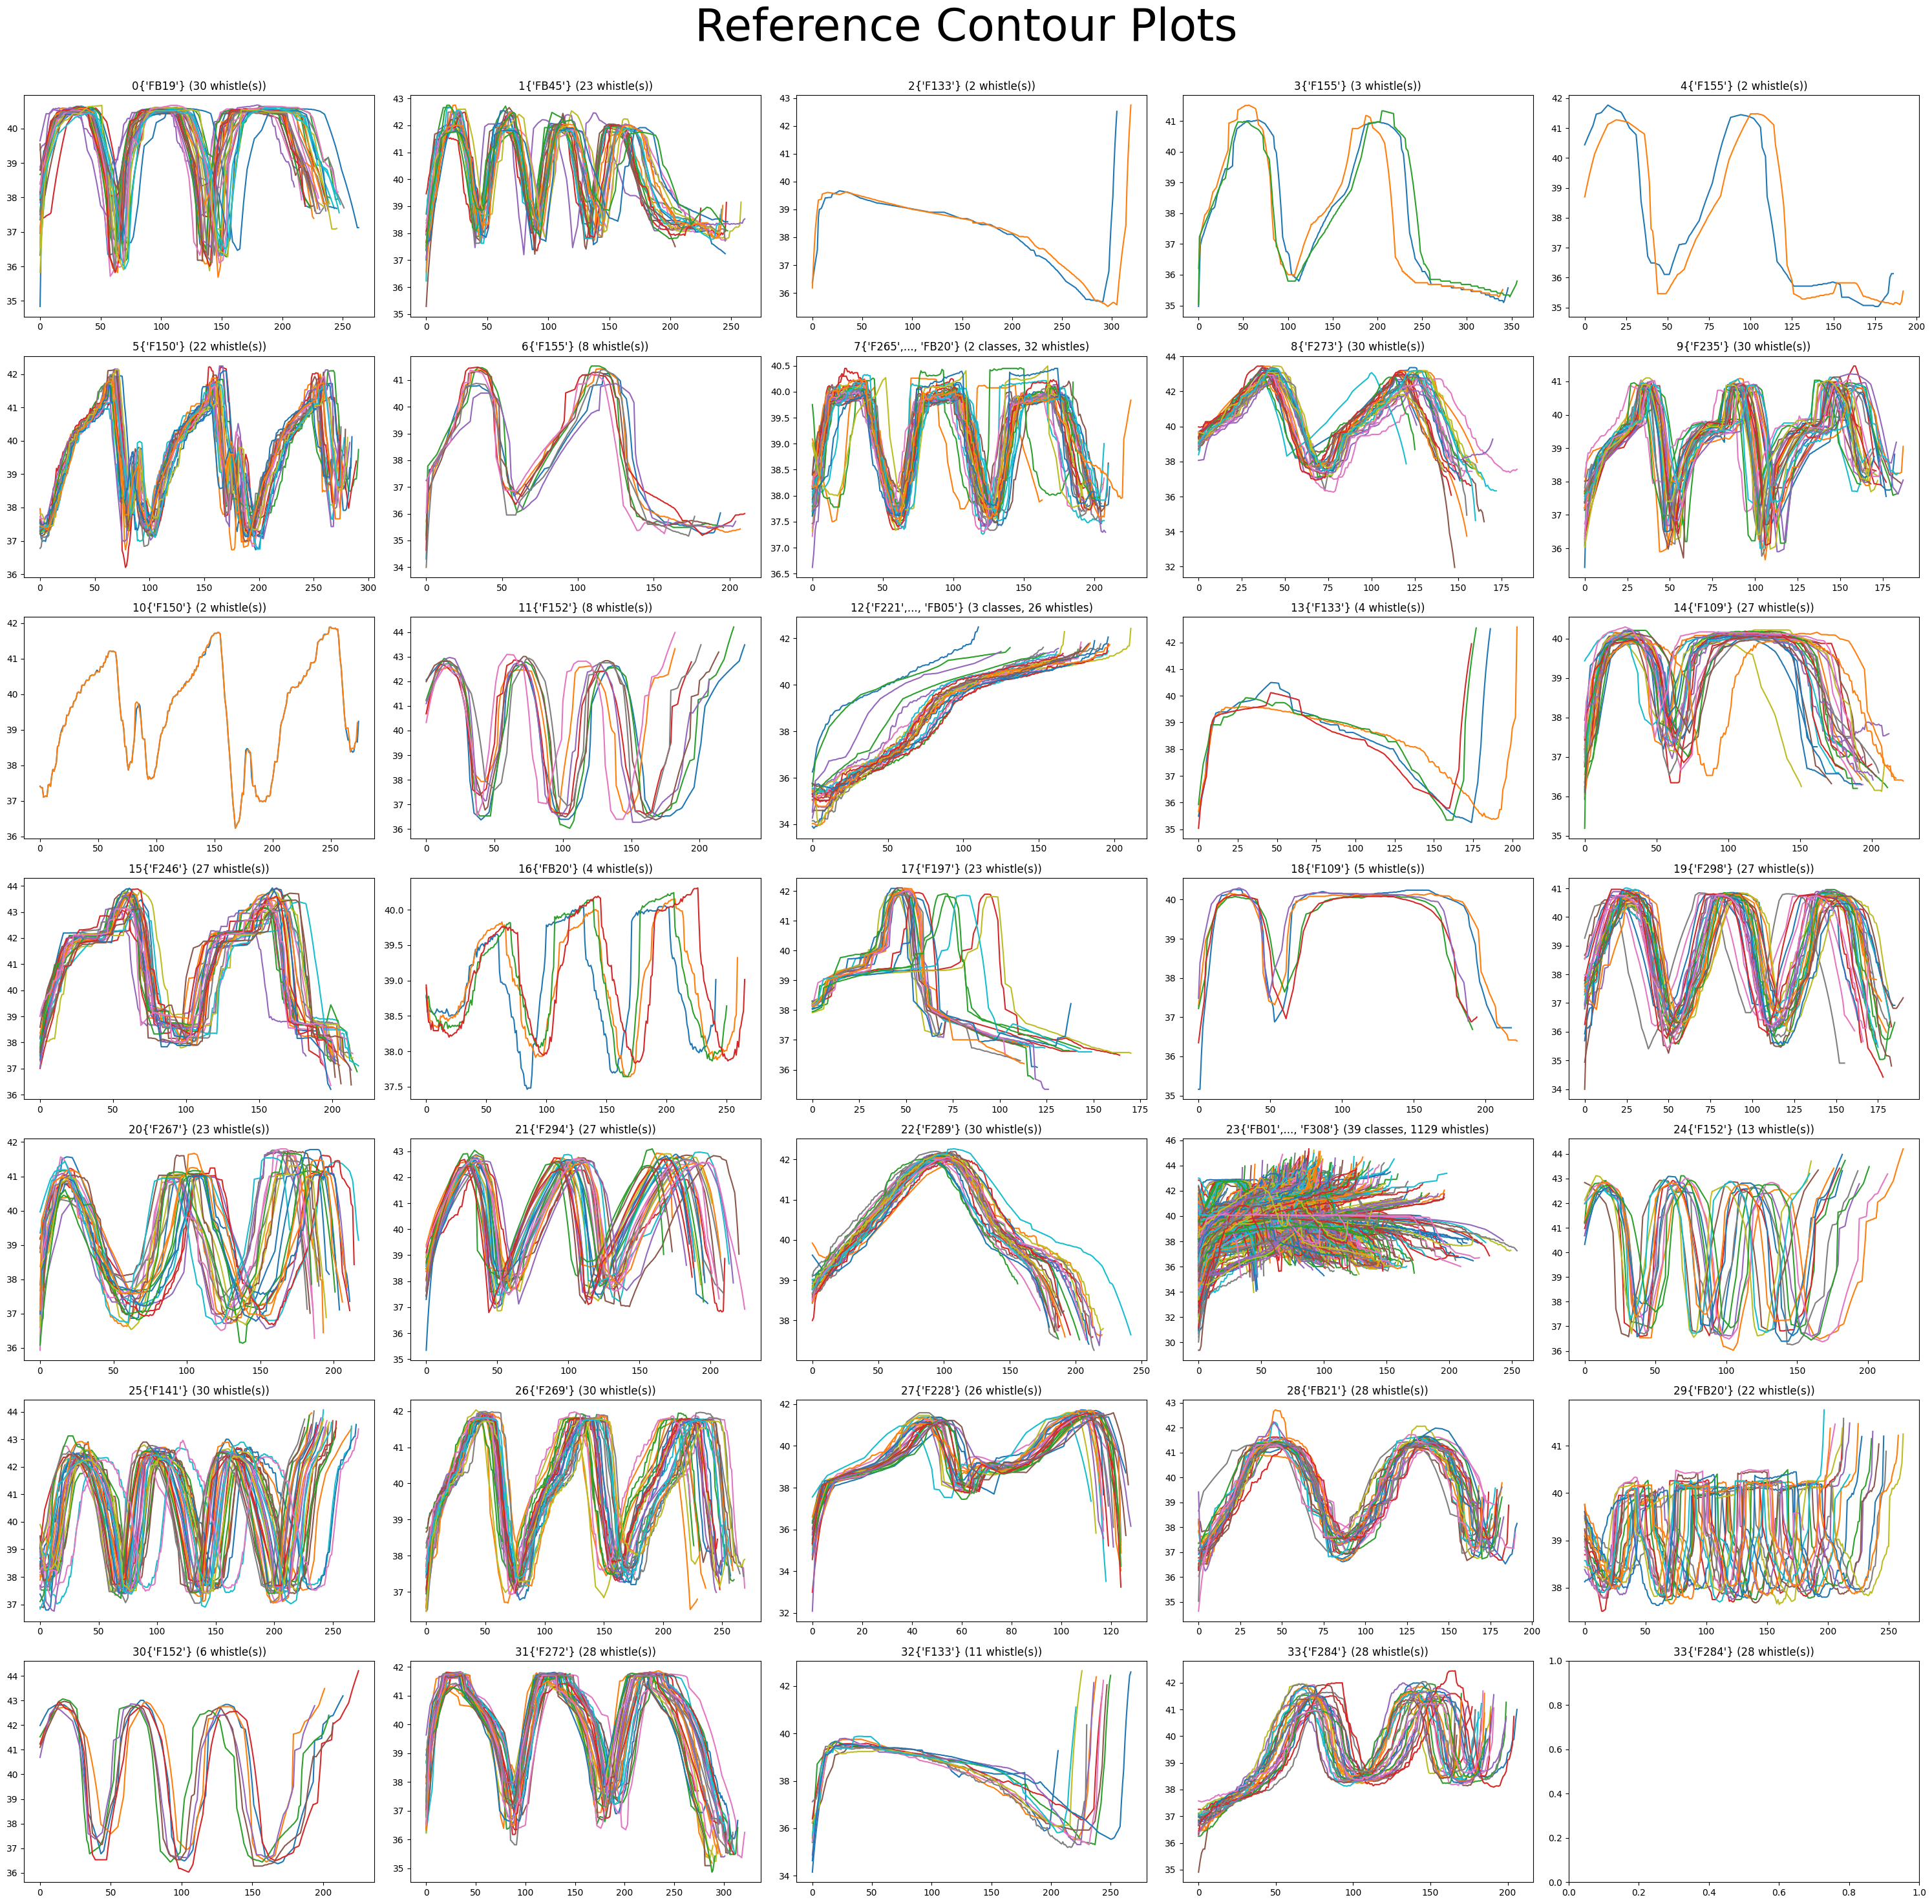

In [92]:
import itertools
categories_copy = categories.copy()
category_names_copy = category_names.copy()

category_ind_copy = category_ind.copy()
num_subsets = 0
for category in category_ind:
  for cat in category_ind:
    if category.issubset(cat) and cat!=category:
      category_ind_copy.remove(category)
      num_subsets += 1
      #print(category, cat)
      break

# get_intersection = lambda a, b: category_ind_copy[a].intersection(category_ind_copy[b])
# pairs = itertools.combinations(range(len(category_ind_copy)), 2)
# res = dict([ (categories_copy, get_intersection(*categories_copy)) for categories_copy in pairs ])

category_ind_copy2 = []
max_len = max([len(i) for i in category_ind_copy])
for category in category_ind_copy:
  cat_tmp = category
  for cat in category_ind_copy:
    if len(cat_tmp.intersection(cat)) > 0.35*len(cat) :
      cat_tmp = cat_tmp.union(cat)

  overlap_present = False
  for i in range(len(category_ind_copy2)):
    if len(cat_tmp.intersection(category_ind_copy2[i])) > 0.9*len(cat_tmp):
      #print("yes")
      category_ind_copy2[i] = cat_tmp.union(category_ind_copy2[i])

      overlap_present = True

  if (cat_tmp not in category_ind_copy2) and not overlap_present and not any([cat_tmp.issubset(c) for c in category_ind_copy2]):
    category_ind_copy2.append(cat_tmp)


# remove any posssible duplicates or subsets remaining after reduction of number of categories
category_ind_copy2 = list(set([frozenset(c) for c in category_ind_copy2]))
category_ind_copy2 = list(set([c for c in category_ind_copy2 if not any([c.issubset(category) and c!=category for category in category_ind_copy2])]))

categories_copy = [[whistles2[i] for i in list(cat)] for cat in category_ind_copy2 if len(cat)>1]
category_names_copy = [[whistle_labels[i] for i in list(cat)] for cat in category_ind_copy2 if len(cat)>1]
uncategorisable_whistles = [[whistles2[i] for i in list(cat)] for cat in category_ind_copy2 if len(cat)<2]

print(sum([len(i) for i in category_names_copy]))
print(len(set(itertools.chain.from_iterable(category_names_copy))), len(set(itertools.chain.from_iterable(category_ind_copy2))), len(list(itertools.chain.from_iterable(category_names_copy))))
print("Number of Categories:", len(categories_copy), "\nSubsets removed:", num_subsets, "\nUncategorisable single whistles:", sum([len(i) for i in uncategorisable_whistles]))

#plt.hist([len(i) for i in category_ind_copy], bins=175)
#plt.hist([whistle_labels], bins=60)
#plt.hist([len(val) for val in res.values()])

num_cols = 5
num_rows = int(len(categories_copy)/num_cols + 1)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 30))


# plot all whistles in final categories
for row_index, ax_row in enumerate(axes):
  for col_index, ax_col in enumerate(ax_row):
    category_num = num_cols*row_index + col_index
    if category_num < len(category_names_copy):
      if len(str(set(category_names_copy[category_num]))) < 16:
        title = f"{category_num}" + str(set(category_names_copy[category_num])) + f" ({len(category_names_copy[category_num])} whistle(s))"
      else:
        title = f"{category_num}" + str(set(category_names_copy[category_num]))[:8] + "...," + str(set(category_names_copy[category_num]))[-8:-1] + "}" \
                                  + f" ({len(set(category_names_copy[category_num]))} classes, " + f"{len(category_names_copy[category_num])} whistles)"
    ax_col.set_title(title)
    if category_num < len(categories_copy):
      for whistle in categories_copy[num_cols*row_index + col_index]:
        ax_col.plot(whistle)
fig.suptitle("Reference Contour Plots\n", fontsize=50)
fig.tight_layout()

# Assessing Accuracy of Method

Assessing the accuracy of this method is difficult because it is an unsupervised classification problem which allows for overlap amongst categories. Standard scores like [normalised mutual information score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) cannot be applied. Generalisations to this metric do exist but are not commonplace in standard Python libaries. One such generalisation which is promising is element-centric clustering (https://doi.org/10.1038/s41598-019-44892-y), which does have a corresponding Python library (https://github.com/Hoosier-Clusters/clusim?tab=readme-ov-file). However, to date (April 2024), there appears to be a bug in the library which prevents it from working.

Some obvious things about accuracy can still however be stated. The clustering algorithm produced 34 categories but we know that 6 actually exist. The clustering algorithm correctly clusters together 6 categories (10%) with complete accuracy. Several more are almost all in their correct category. There is an anomalous category containing over 1000 whistles. This is likely restricting categorisation into the required 60. It is unclear why this is occurring as many attempts at avoiding ths were made. Additionally, 91 whistle were deemed "unclassifiable", meaning that they did not match the similarity threshold with any other whistle in the dataset for the parameters used.

On a purely visual and qualitative level, the algorithm does seem to have roughly the "right idea" about the shapes it categorising.